In [2]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [3]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [5]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [6]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t

path ../datasets/drum_midi/50´s Drummer MIDI Files/04 Country/10 Rough Rider 183BPM
  01 8th Perc.mid
  02 8th Perc.mid
  03 8th Hat.mid
  04 8th Ride.mid
  05 8th Toms.mid
  06 8th Multi.mid
  07 8th Hat.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/05 Jazz
path ../datasets/drum_midi/50´s Drummer MIDI Files/05 Jazz/01 Amel 85BPM Brushes
  01 8th Snare.mid
  02 8th Snare.mid
  03 8th HiHat.mid
  04 8th Snare.mid
  05 8th Ride.mid
  06 8th Hat.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/05 Jazz/02 Another You 170BPM
  01 8th Ride.mid
  02 8th Ride.mid
  03 8th Ride.mid
  04 8th Snare.mid
  05 8th Multi.mid
  06 8th Multi.mid
  07 8th Multi.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/05 Jazz/03 Cool 137BPM Brushes
  01 8th Toms.mid
  02 8th Snare.mid
  03 8th Multi.mid
  04 8th Toms.mid
  05 16th Snare.mid
  06 16th Toms.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/05 Jazz/04 Silent Tear 234BPM
  01 8th Snare.

In [7]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [50]:
# [(i,k) for i,k in enumerate(labels)]

In [9]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [11]:
unique_genres = set(genre[-2] +'/'+ genre[-1] for genre in genres)
len(unique_genres)

72

In [16]:
# unique_genres

In [13]:
x_train.shape

(500, 160, 10, 1)

In [14]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres)

In [23]:
labels_ = [label.split('/') for label in labels]
label_dict = setup.build_label_dict(labels_)
label_dict

defaultdict(list,
            {'01 Dancin Rick 166BPM/01 8th Hat.mid': [0],
             '01 Dancin Rick 166BPM/02 8th Ride.mid': [1],
             '01 Dancin Rick 166BPM/03 16th Snare.mid': [2],
             '01 Dancin Rick 166BPM/04 8th Ride.mid': [3],
             '01 Dancin Rick 166BPM/05 16th Ride.mid': [4],
             '01 Dancin Rick 166BPM/06 16th Ride.mid': [5],
             '01 Dancin Rick 166BPM/07 16th Ride.mid': [6],
             '02 Gogo 191BPM/01 8th Hat.mid': [7],
             '02 Gogo 191BPM/02 8th Snare.mid': [8],
             '02 Gogo 191BPM/03 4th Snare .mid': [9],
             '02 Gogo 191BPM/04 8th Ride.mid': [10],
             '02 Gogo 191BPM/05 8th Snare.mid': [11],
             '02 Gogo 191BPM/06 8th Toms.mid': [12],
             '02 Gogo 191BPM/07 8th Toms.mid': [13],
             '03 Lips n Hips 152BPM/01 8th Perc.mid': [14],
             '03 Lips n Hips 152BPM/02 8th Ride.mid': [15],
             '03 Lips n Hips 152BPM/03 8th Ride .mid': [16],
             

In [24]:
# i = 0
# j = 399
# plot.single(x_train[i, :50,:,0])
# plot.single(x_train[j, :50,:,0])
# # plot.single(x_train[2a, :50,:,0])
# np.array(labels)[[i,j]]

In [25]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [26]:
latent_dim = 10
epsilon_std = 1.0

In [27]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


In [28]:
batch_size = 128
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [29]:
# phase_mod = 0.01
# whitening = False

In [30]:
name = 'non-functional_model.h5'
fn = config.model_dir + name

In [31]:
# io.save_dict('../logs/','train_loss', history)

In [32]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [33]:
vae.load_weights(fn)

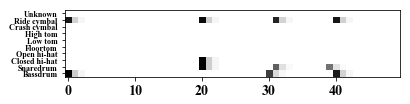

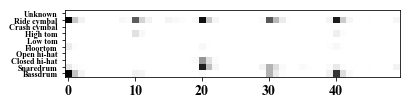

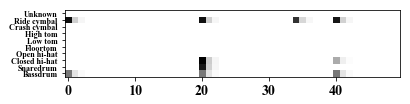

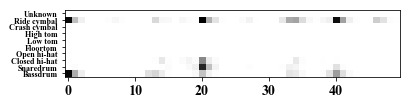

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [34]:
i,j = 240, 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

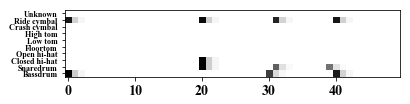

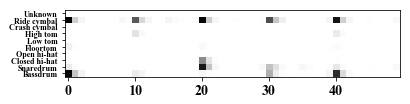

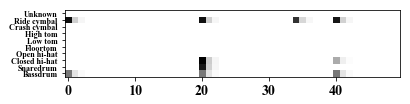

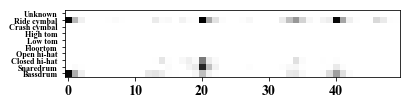

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [35]:
i,j = 0, 10
i,j = 240, 30

m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [36]:
decoder = generator

## Style transfer

In [37]:
m = 500
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(500, 10)

In [38]:
# a = list({3:[2],'s':[3,3]}.keys())
# np.random.shuffle(a)
# a

In [39]:
import transformation_extraction

In [40]:
best_dims, importances, transformations, min_transformations = \
    transformation_extraction.between_genres(x_train_encoded, label_dict, amt1=1000, amt2=1, v=1)


0
Genre A: 07 Straight 88BPM/07 16th Ride.mid
  genre B: 	09 Slow Shuffle 80BPM/02 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

1
Genre A: 08 Cecil Cee 101BPM/01 8th Ride.mid
  genre B: 	07 Ride Swing 95Bpm/02 8th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

2
Genre A: 06 Vidar Vega 70BPM/05 8th Toms.mid
  genre B: 	11 Disco Dancer 135BPM/02 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

3
Genre A: 01 Dancin Rick 166BPM/02 8th Ride.mid
  genre B: 	05 TNT 116BPM/03 8th HiHat.mid (len: 1)
 	 i: 2, importance: 0.072000

4
Genre A: 10 Rough Rider 183BPM/02 8th Perc.mid
  genre B: 	12 Sticks Up 155BPM/01 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

5
Genre A: 10 Scalis 190BPM 3-4/02 8th hat.mid
  genre B: 	04 Snarey 208BPM 3-4/04 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

6
Genre A: 04 Silent Tear 234BPM/05 8th Multi.mid
  genre B: 	07 Thwag 170BPM/02 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

7
Genre A: 02 Another You 170BPM/01 8th Ride.mid
  ge

  genre B: 	04 Love 155BPM/06 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

61
Genre A: 02 Another You 170BPM/01 8th Ride.mid
  genre B: 	05 TNT 116BPM/05 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

62
Genre A: 08 Cecil Cee 101BPM/01 8th Ride.mid
  genre B: 	11 Disco Dancer 135BPM/03 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

63
Genre A: 03 Cadence Soul 105BPM/03 8th Hat.mid
  genre B: 	09 Distel 155BPM/04 8th Tom.mid (len: 1)
 	 i: 2, importance: 0.072000

64
Genre A: 04 Snarey 208BPM 3-4/02 8th Snare.mid
  genre B: 	06 JB Groove 115BPM/04 4th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

65
Genre A: 05 TNT 116BPM/06 8th Ride.mid
  genre B: 	07 Thwag 170BPM/01 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

66
Genre A: 06 Moonglow 140BPM/04 8th Perc.mid
  genre B: 	06 JB Groove 115BPM/03 4th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

67
Genre A: 08 Sams 127BPM/05 8th Perc.mid
  genre B: 	10 Syncopated Ride 128BPM/07 16th Hat.mid (len: 1)
 	 i: 2, im

  genre B: 	09 West Coast 152BPM Brushes/01 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

122
Genre A: 04 Love 155BPM/05 8th Ride.mid
  genre B: 	01 Booze 92BPM/06 8th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

123
Genre A: 06 Bopop 130MPM/02 8th Ride.mid
  genre B: 	04 Silent Tear 234BPM/04 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

124
Genre A: 02 Another You 170BPM/07 8th Multi.mid
  genre B: 	05 Hip Hop 95BPM/04 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

125
Genre A: 06 Vidar Vega 70BPM/02 8th Hat.mid
  genre B: 	08 Cecil Cee 101BPM/05 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

126
Genre A: 06 Nucleus 172BPM Brushes/05 8th Hat.mid
  genre B: 	09 Smooth Soul 81BPM/03 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

127
Genre A: 08 Eddie Ed 111BPM/07 8th Perc.mid
  genre B: 	07 Trainy 100BPM/03 16th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

128
Genre A: 09 Slow Shuffle 80BPM/03 16th Hat.mid
  genre B: 	04 GoGo Soul 100BPM/01 16th

  genre B: 	06 Moonglow 140BPM/04 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

182
Genre A: 02 Gogo 191BPM/05 8th Snare.mid
  genre B: 	04 Mickeys 212BPM 12-8/02 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

183
Genre A: 02 Frankies Girl 116BPM/05 8th Ride.mid
  genre B: 	08 Sams 127BPM/05 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

184
Genre A: 04 Mickeys 212BPM 12-8/03 8th Cym.mid
  genre B: 	05 Brewer 160BPM/06 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

185
Genre A: 05 Hip Hop 95BPM/05 16th Hat.mid
  genre B: 	09 Leroyes 130BPM/06 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

186
Genre A: 08 Bouncer 162BPM/01 8th Cym.mid
  genre B: 	05 Cadillac 128BPM/04 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

187
Genre A: 05 TNT 116BPM/02 8th Snare.mid
  genre B: 	11 Disco Dancer 135BPM/02 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

188
Genre A: 09 Slow Shuffle 80BPM/02 16th Hat.mid
  genre B: 	03 Lips n Hips 152BPM/02 8th Ride.mid (len: 

  genre B: 	05 Halftime 71BPM/05 16th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

243
Genre A: 10 Chilled 120BPM/04 8th Hat.mid
  genre B: 	09 Slow Shuffle 80BPM/04 16th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

244
Genre A: 07 Kooper 234BPM/02 4th Multi.mid
  genre B: 	02 Marching 94BPM/03 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

245
Genre A: 09 Smooth Soul 81BPM/04 16th Hat.mid
  genre B: 	03 King Quiza 102BPM/04 16th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

246
Genre A: 06 Bopop 130MPM/07 8th Hat.mid
  genre B: 	01 Rock Shuffle 130BPM/04 4th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

247
Genre A: 09 Distel 155BPM/04 8th Tom.mid
  genre B: 	02 Another You 170BPM/04 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

248
Genre A: 06 Vidar Vega 70BPM/04 8th Hat.mid
  genre B: 	05 Halftime 71BPM/04 16th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

249
Genre A: 06 Moonglow 140BPM/04 8th Perc.mid
  genre B: 	07 Rock Keeler 133BPM/04 8th Perc.mid (l

  genre B: 	10 Frewild 152BPM/06 16th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

303
Genre A: 09 Broonze 122BPM/01 8th Hat.mid
  genre B: 	08 Rim Soul 90BPM/01 4th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

304
Genre A: 02 Frankies Girl 116BPM/06 8th Ride.mid
  genre B: 	03 Cadence Soul 105BPM/05 4th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

305
Genre A: 10 Bogeart 122BPM/03 8th Ride.mid
  genre B: 	04 Titanic 97BPM/02 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

306
Genre A: 10 Syncopated Ride 128BPM/06 16th Cym.mid
  genre B: 	03 Moon 137BPM/03 8th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

307
Genre A: 04 Love 155BPM/02 8th Hat.mid
  genre B: 	10 Scalis 190BPM 3-4/02 8th hat.mid (len: 1)
 	 i: 2, importance: 0.072000

308
Genre A: 04 Love 155BPM/01 8th Hat.mid
  genre B: 	08 Neodop 226BPM 3-4/01 16th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

309
Genre A: 02 Gogo 191BPM/03 4th Snare .mid
  genre B: 	02 Another You 170BPM/03 8th Ride.mid (len: 1)
 

  genre B: 	10 Frewild 152BPM/06 16th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

363
Genre A: 03 Noton Bull 192BPM 12-8 Brushes/04 4th Perc.mid
  genre B: 	05 Hip Hop 95BPM/07 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

364
Genre A: 10 Syncopated Ride 128BPM/06 16th Cym.mid
  genre B: 	10 Rough Rider 183BPM/06 8th Multi.mid (len: 1)
 	 i: 2, importance: 0.072000

365
Genre A: 01 Fly High 115BPM/01 8th Hat.mid
  genre B: 	05 Straight Line 136BPM/01 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

366
Genre A: 04 Maybelline 233BPM/02 8th Cym.mid
  genre B: 	03 Straight 72BPM Brushes/01 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

367
Genre A: 05 Halftime 71BPM/01 16th Hat.mid
  genre B: 	07 Rock Keeler 133BPM/02 4th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

368
Genre A: 10 Rough Rider 183BPM/05 8th Toms.mid
  genre B: 	04 Snarey 208BPM 3-4/04 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

369
Genre A: 05 Brewer 160BPM/04 8th Snare.mid
  genre B: 	0

  genre B: 	08 Cecil Cee 101BPM/04 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

423
Genre A: 07 Trainy 100BPM/04 16th Toms.mid
  genre B: 	02 Marching 94BPM/04 8th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

424
Genre A: 02 Rock Tribal 125BPM/03 4th Toms.mid
  genre B: 	07 Trainy 100BPM/03 16th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

425
Genre A: 01 Fly High 115BPM/07 8th Multi.mid
  genre B: 	03 Lips n Hips 152BPM/06 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

426
Genre A: 02 Nappy Brown 160BPM/06 8th Perc.mid
  genre B: 	02 Frankies Girl 116BPM/04 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

427
Genre A: 09 West Coast 152BPM Brushes/05 8th Multi.mid
  genre B: 	09 West Coast 152BPM Brushes/06 8th Multi.mid (len: 1)
 	 i: 2, importance: 0.072000

428
Genre A: 07 Lester Lee 133BPM/07 8th Ride.mid
  genre B: 	02 Boogaloo 120BPM/01 16th Multi.mid (len: 1)
 	 i: 2, importance: 0.072000

429
Genre A: 10 Scalis 190BPM 3-4/07 8th Snare.mid
  genre B: 	02

  genre B: 	01 Booze 92BPM/06 8th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

483
Genre A: 06 Vidar Vega 70BPM/02 8th Hat.mid
  genre B: 	10 Frewild 152BPM/01 4th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

484
Genre A: 01 Soul Groove 107BPM/03 8th Hat.mid
  genre B: 	08 Neodop 226BPM 3-4/03 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

485
Genre A: 09 West Coast 152BPM Brushes/02 8th Snare.mid
  genre B: 	06 JB Groove 115BPM/04 4th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

486
Genre A: 07 Straight 88BPM/05 8th Hat.mid
  genre B: 	09 Diddeley 185bpm/02 4th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

487
Genre A: 04 Maybelline 233BPM/01 8th Snare.mid
  genre B: 	06 Vidar Vega 70BPM/07 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

488
Genre A: 02 Another You 170BPM/06 8th Multi.mid
  genre B: 	08 Doowoop 140bpm/06 16th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

489
Genre A: 02 Frankies Girl 116BPM/06 8th Ride.mid
  genre B: 	10 Rough Rider 183BPM/03

  genre B: 	01 Dancin Rick 166BPM/04 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

543
Genre A: 03 Lips n Hips 152BPM/06 8th Hat.mid
  genre B: 	07 Kooper 234BPM/07 16th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

544
Genre A: 08 Eddie Ed 111BPM/04 4th Cym.mid
  genre B: 	10 Chilled 120BPM/06 8th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

545
Genre A: 08 Sams 127BPM/01 8th Hat.mid
  genre B: 	04 Snarey 208BPM 3-4/01 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

546
Genre A: 01 Rock Shuffle 130BPM/05 12th Hat.mid
  genre B: 	10 Ottis 172bpm/07 8th Multi.mid (len: 1)
 	 i: 2, importance: 0.072000

547
Genre A: 10 Bogeart 122BPM/02 8th Hat.mid
  genre B: 	07 Thwag 170BPM/01 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

548
Genre A: 04 Love 155BPM/03 8th Ride.mid
  genre B: 	02 Nappy Brown 160BPM/05 8th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

549
Genre A: 02 Another You 170BPM/05 8th Multi.mid
  genre B: 	07 Trainy 100BPM/02 16th Snare.mid (len: 1)


  genre B: 	09 Slow Shuffle 80BPM/04 16th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

603
Genre A: 08 Bouncer 162BPM/05 8th Hat.mid
  genre B: 	01 Rock Shuffle 130BPM/03 8th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

604
Genre A: 05 Hip Hop 95BPM/03 16th Hat.mid
  genre B: 	04 Maybelline 233BPM/05 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

605
Genre A: 06 Nucleus 172BPM Brushes/02 8th Toms.mid
  genre B: 	08 Sams 127BPM/07 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

606
Genre A: 03 Noton Bull 192BPM 12-8 Brushes/01 4th Multi.mid
  genre B: 	02 Frankies Girl 116BPM/05 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

607
Genre A: 01 Rock Shuffle 130BPM/04 4th Cym.mid
  genre B: 	03 Cadence Soul 105BPM/07 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

608
Genre A: 07 Straight 88BPM/02 8th Ride.mid
  genre B: 	06 Moonglow 140BPM/03 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

609
Genre A: 04 GoGo Soul 100BPM/04 8th Hat.mid
  genre B: 	07 Lester 

  genre B: 	02 Another You 170BPM/04 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

663
Genre A: 05 Brewer 160BPM/05 8th Toms.mid
  genre B: 	06 Vidar Vega 70BPM/01 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

664
Genre A: 08 Doowoop 140bpm/07 16th Perc.mid
  genre B: 	03 Cadence Soul 105BPM/07 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

665
Genre A: 01 Rock Shuffle 130BPM/01 8th Toms.mid
  genre B: 	07 Straight 88BPM/05 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

666
Genre A: 08 Doowoop 140bpm/07 16th Perc.mid
  genre B: 	04 Snarey 208BPM 3-4/06 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

667
Genre A: 05 Cadillac 128BPM/02 8th Hat.mid
  genre B: 	07 Trainy 100BPM/07 16th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

668
Genre A: 03 Lips n Hips 152BPM/02 8th Ride.mid
  genre B: 	10 Ottis 172bpm/04 8th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

669
Genre A: 05 Hip Hop 95BPM/06 16th Hat.mid
  genre B: 	08 Bouncer 162BPM/01 8th Cym.mid (len

  genre B: 	10 Rough Rider 183BPM/04 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

724
Genre A: 04 Love 155BPM/02 8th Hat.mid
  genre B: 	09 West Coast 152BPM Brushes/03 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

725
Genre A: 04 Mickeys 212BPM 12-8/07 8th perc.mid
  genre B: 	08 Neodop 226BPM 3-4/02 16th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

726
Genre A: 04 GoGo Soul 100BPM/03 8th Hat.mid
  genre B: 	10 Syncopated Ride 128BPM/01 16th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

727
Genre A: 02 Frankies Girl 116BPM/05 8th Ride.mid
  genre B: 	02 Frankies Girl 116BPM/07 8th Multi.mid (len: 1)
 	 i: 2, importance: 0.072000

728
Genre A: 01 Amel 85BPM Brushes/07 16th Ride.mid
  genre B: 	06 Bopop 130MPM/06 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

729
Genre A: 01 Rock Shuffle 130BPM/02 8th Hat.mid
  genre B: 	05 Halftime 71BPM/04 16th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

730
Genre A: 06 Bopop 130MPM/02 8th Ride.mid
  genre B: 	02 Another

  genre B: 	02 Marching 94BPM/02 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

784
Genre A: 07 Rock Keeler 133BPM/06 8th Cym.mid
  genre B: 	04 GoGo Soul 100BPM/05 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

785
Genre A: 07 Thwag 170BPM/01 8th Ride.mid
  genre B: 	11 Disco Dancer 135BPM/02 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

786
Genre A: 08 Neodop 226BPM 3-4/07 8th Multi.mid
  genre B: 	01 Rock Shuffle 130BPM/05 12th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

787
Genre A: 10 Bogeart 122BPM/07 8th Toms.mid
  genre B: 	07 Straight 88BPM/04 16th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

788
Genre A: 09 West Coast 152BPM Brushes/06 8th Multi.mid
  genre B: 	03 King Quiza 102BPM/05 16th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

789
Genre A: 06 Vidar Vega 70BPM/02 8th Hat.mid
  genre B: 	01 Fly High 115BPM/05 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

790
Genre A: 06 Swing Funk 102BPM/04 8th Cym.mid
  genre B: 	03 Noton Bull 192BP

  genre B: 	08 Doowoop 140bpm/07 16th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

844
Genre A: 02 Boogaloo 120BPM/06 16th Hat.mid
  genre B: 	08 Sams 127BPM/03 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

845
Genre A: 07 Kooper 234BPM/07 16th Toms.mid
  genre B: 	07 Kooper 234BPM/03 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

846
Genre A: 10 Frewild 152BPM/01 4th Hat.mid
  genre B: 	10 Bogeart 122BPM/03 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

847
Genre A: 04 GoGo Soul 100BPM/01 16th Toms.mid
  genre B: 	02 Marching 94BPM/04 8th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

848
Genre A: 05 Hip Hop 95BPM/02 16th Hat.mid
  genre B: 	06 Swing Funk 102BPM/01 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

849
Genre A: 01 Soul Groove 107BPM/03 8th Hat.mid
  genre B: 	09 Smooth Soul 81BPM/07 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

850
Genre A: 08 Neodop 226BPM 3-4/06 8th Multi.mid
  genre B: 	04 Titanic 97BPM/03 4th Cym.mid (len: 1)
 	 i: 

  genre B: 	06 Moonglow 140BPM/07 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

904
Genre A: 06 Bopop 130MPM/02 8th Ride.mid
  genre B: 	07 Rock Keeler 133BPM/04 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

905
Genre A: 02 Boogaloo 120BPM/06 16th Hat.mid
  genre B: 	09 West Coast 152BPM Brushes/05 8th Multi.mid (len: 1)
 	 i: 2, importance: 0.072000

906
Genre A: 05 Halftime 71BPM/04 16th Cym.mid
  genre B: 	04 Love 155BPM/05 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

907
Genre A: 01 Calvin 148BPM/01 8th Snare.mid
  genre B: 	06 Swing Funk 102BPM/07 8th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

908
Genre A: 02 Rock Tribal 125BPM/06 16th Hat.mid
  genre B: 	06 Swing Funk 102BPM/06 8th Cym.mid (len: 1)
 	 i: 2, importance: 0.072000

909
Genre A: 01 Dancin Rick 166BPM/01 8th Hat.mid
  genre B: 	01 Amel 85BPM Brushes/01 8th Snare.mid (len: 1)
 	 i: 2, importance: 0.072000

910
Genre A: 01 Calvin 148BPM/06 8th Toms.mid
  genre B: 	10 Scalis 190BPM 3-4/01 8th S

  genre B: 	05 Your Eyes 80BPM/04 16th Toms.mid (len: 1)
 	 i: 2, importance: 0.072000

964
Genre A: 05 Brewer 160BPM/02 8th Hat.mid
  genre B: 	02 Nappy Brown 160BPM/06 8th Perc.mid (len: 1)
 	 i: 2, importance: 0.072000

965
Genre A: 10 Bogeart 122BPM/07 8th Toms.mid
  genre B: 	02 Frankies Girl 116BPM/07 8th Multi.mid (len: 1)
 	 i: 2, importance: 0.072000

966
Genre A: 05 Cadillac 128BPM/04 8th Perc.mid
  genre B: 	02 Nappy Brown 160BPM/01 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

967
Genre A: 10 Ottis 172bpm/05 8th Toms.mid
  genre B: 	01 Soul Groove 107BPM/04 16th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

968
Genre A: 06 Swing Funk 102BPM/03 8th Hat.mid
  genre B: 	01 Calvin 148BPM/04 8th Hat.mid (len: 1)
 	 i: 2, importance: 0.072000

969
Genre A: 07 Trainy 100BPM/02 16th Snare.mid
  genre B: 	04 Love 155BPM/05 8th Ride.mid (len: 1)
 	 i: 2, importance: 0.072000

970
Genre A: 04 Mickeys 212BPM 12-8/07 8th perc.mid
  genre B: 	04 Love 155BPM/07 8th Perc.mid (len: 

In [41]:
print('avg importance: %f' % np.mean(importances))

avg importance: 0.072000


In [42]:
# list(min_transformations.items())[0]

In [43]:
for genre_A, d in min_transformations.items():
    print('\nGenre `%s` to: \n dim:\tgenre:' % genre_A)
    for genre_B, vector in d.items():
        print(' %i \t%s' % (np.argmax(vector), genre_B))  


Genre `07 Straight 88BPM/07 16th Ride.mid` to: 
 dim:	genre:
 0 	09 West Coast 152BPM Brushes/02 8th Snare.mid

Genre `08 Cecil Cee 101BPM/01 8th Ride.mid` to: 
 dim:	genre:
 2 	07 Kooper 234BPM/02 4th Multi.mid

Genre `06 Vidar Vega 70BPM/05 8th Toms.mid` to: 
 dim:	genre:
 0 	11 Disco Dancer 135BPM/04 16th Hat.mid

Genre `01 Dancin Rick 166BPM/02 8th Ride.mid` to: 
 dim:	genre:
 0 	05 TNT 116BPM/03 8th HiHat.mid

Genre `10 Rough Rider 183BPM/02 8th Perc.mid` to: 
 dim:	genre:
 0 	02 Rock Tribal 125BPM/03 4th Toms.mid

Genre `10 Scalis 190BPM 3-4/02 8th hat.mid` to: 
 dim:	genre:
 2 	03 Lips n Hips 152BPM/05 8th Snare.mid

Genre `04 Silent Tear 234BPM/05 8th Multi.mid` to: 
 dim:	genre:
 2 	10 Rough Rider 183BPM/07 8th Hat.mid

Genre `02 Another You 170BPM/01 8th Ride.mid` to: 
 dim:	genre:
 0 	10 Scalis 190BPM 3-4/02 8th hat.mid

Genre `09 Diddeley 185bpm/03 4th Ride.mid` to: 
 dim:	genre:
 0 	03 Noton Bull 192BPM 12-8 Brushes/07 4th Mulit.mid

Genre `01 Dancin Rick 166BPM/04 8th Ri

(array([  0.,   0.,   0.,   0.,   0., 999.,   0.,   0.,   0.,   0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <a list of 10 Patch objects>)

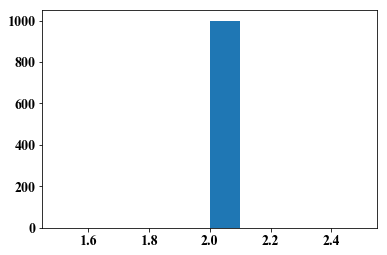

In [44]:
plt.hist(best_dims)

In [48]:
# TODO save as python object (or json)

In [45]:
# def save_transformation_dicts(transformations={}, dn='', v=0):
#     for genre_A, sub_dict in transformations.items():
#         # sub_dict :: {'genre_B_2/genre_B_2': vector}
#         a1, a2 = genre_A.split('/')
#         if a1 not in os.listdir(dn): os.mkdir(dn + a1)
#         if v:
#             print(genre_A)
#             print(sub_dict.keys())
#         io.save_dict(dn + a1, a2, sub_dict)

fn = config.plots_dir + 'transformations-one-to-one-best_dims.pkl'
io.save(best_dims, fn)

fn = config.plots_dir + 'transformations-one-to-one.pkl'
io.save(transformations, fn)

fn = config.plots_dir + 'min_transformations-one-to-one.pkl'
io.save(min_transformations, fn)

'../results/min_transformations-one-to-one.pkl'

In [46]:
t_ = io.load(fn)

In [47]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [48]:
list(transformations.keys())[:3]

['07 Straight 88BPM/07 16th Ride.mid',
 '08 Cecil Cee 101BPM/01 8th Ride.mid',
 '06 Vidar Vega 70BPM/05 8th Toms.mid']

In [49]:
len(transformations.keys())

428